In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

#### Importing data and overview of the data

In [156]:
df = pd.read_csv('data/stud_perf_model.csv')

In [157]:
df.head()

,gender,race,parental level of education,lunch,test preparation course,math score,reading score,writing score,total score,average score
0,female,group B,bachelor's degree,standard,none,72,72,74,218,72.666667
1,female,group C,some college,standard,completed,69,90,88,247,82.333333
2,female,group B,master's degree,standard,none,90,95,93,278,92.666667
3,male,group A,associate's degree,free/reduced,none,47,57,44,148,49.333333
4,male,group C,some college,standard,none,76,78,75,229,76.333333


#### Preparing the X and Y variables
The column to predict will be the average score. All the feautres except the total score and the writing score score will be used

In [158]:
x = df.drop(columns = ['average score', 'total score', 'writing score'])

In [159]:
x.head()

,gender,race,parental level of education,lunch,test preparation course,math score,reading score
0,female,group B,bachelor's degree,standard,none,72,72
1,female,group C,some college,standard,completed,69,90
2,female,group B,master's degree,standard,none,90,95
3,male,group A,associate's degree,free/reduced,none,47,57
4,male,group C,some college,standard,none,76,78


In [160]:
y = df['average score']

In [161]:
y.head()

0    72.666667
1    82.333333
2    92.666667
3    49.333333
4    76.333333
Name: average score, dtype: float64

In [162]:
y.shape

(1000,)

In [163]:
for col in x.select_dtypes(include = 'object').columns:
    xx = df[f'{col}'].unique()
    print(f"The unique values in the {col} column are : {xx}")
    print('\n')

The unique values in the gender column are : ['female' 'male']


The unique values in the race column are : ['group B' 'group C' 'group A' 'group D' 'group E']


The unique values in the parental level of education column are : ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']


The unique values in the lunch column are : ['standard' 'free/reduced']


The unique values in the test preparation course column are : ['none' 'completed']




#### Creating column transformers

In [164]:
num_feat = x.select_dtypes(exclude = 'object').columns
cat_feat = x.select_dtypes(include = 'object').columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

num_trans = StandardScaler() #this transforms the data so that the data has a mean of 0 and a standard deviation of 1
cat_trans = OneHotEncoder() #this converts categorical variables into binary vectors, where each category is represented as a binary column, and the presence or absence of a category is indicated by 1 or 0, respectivel

preprocessor = ColumnTransformer( [
    ("One_hot_encoder", cat_trans, cat_feat),
    ('standardscaler', num_trans, num_feat)
])

In [165]:
x_preprocessed = preprocessor.fit_transform(x)

In [166]:
x_preprocessed.shape

(1000, 19)

#### Separating data into training and testing data set

In [167]:
x_train, x_test, y_train, y_test = train_test_split(x_preprocessed, y, test_size = 0.2, random_state = 31)
x_train.shape, x_test.shape

((800, 19), (200, 19))

#### Creating an model evaluation function to provide metrics after training completion

In [168]:
def model_evaluate(truth, prediction):
    mae = mean_absolute_error(truth, prediction) #this measures magnitude of the errors wihtout considering the direction. lower mae indicates better model prediction
    mse = mean_squared_error(truth, prediction) #emphasizes larger errors and penalizes them more than smaller errors
    rmse = np.sqrt(mean_squared_error(truth, prediction))#this is the square root of mse.
    r2 = r2_score(truth, prediction) #The R-squared, also known as the coefficient of determination, measures the proportion of variance in the target variable that is explained by the model. R2 ranges from 0 to 1, where 0 indicates that the model does not explain any variance, and 1 indicates a perfect fit
    return mae, rmse, r2

In [169]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}

list_of_models = []
list_of_r2_score = []

for a in range(len(models)):
    model_name = list(models.keys())[a]
    model = list(models.values())[a] #this gets the instance of the models, as the loop goes one by one
    model.fit(x_train, y_train) #this trains the model

    train_pred = model.predict(x_train) #this makes the predictions on the training set
    test_pred = model.predict(x_test) #this makes the predictions on the testing set

    #these get evaluate the individual model and get the score for the same training and testing dataset
    train_mae, train_rmse, train_r2 = model_evaluate(y_train, train_pred)
    test_mae, test_rmse, test_r2 = model_evaluate(y_test, test_pred)

    #adding the model and the respective r2 score for the test dataset
    list_of_models.append(model_name)
    list_of_r2_score.append(test_r2)

    #display the performance
    print('Model: '+ model_name)
    print('performance for training data set')
    print(f'- Mean Absolute Error: {train_mae:.2f}')
    print(f'- Root Mean Squared Error: {train_rmse:.2f}')
    print(f'- R2 Score: {train_r2:.2f}')
    print('/n')
    print('performance for testing data set')
    print(f'- Mean Absolute Error: {test_mae:.2f}')
    print(f'- Root Mean Squared Error: {test_rmse:.2f}')
    print(f'- R2 Score: {test_r2:.2f}')
    print('='*30)
    print('/n')
    
    

Model: Linear Regression
performance for training data set
- Mean Absolute Error: 0.93
- Root Mean Squared Error: 1.15
- R2 Score: 0.99
/n
performance for testing data set
- Mean Absolute Error: 0.97
- Root Mean Squared Error: 1.19
- R2 Score: 0.99
/n
Model: Lasso
performance for training data set
- Mean Absolute Error: 1.47
- Root Mean Squared Error: 1.82
- R2 Score: 0.98
/n
performance for testing data set
- Mean Absolute Error: 1.55
- Root Mean Squared Error: 1.91
- R2 Score: 0.98
/n
Model: Ridge
performance for training data set
- Mean Absolute Error: 0.93
- Root Mean Squared Error: 1.15
- R2 Score: 0.99
/n
performance for testing data set
- Mean Absolute Error: 0.97
- Root Mean Squared Error: 1.19
- R2 Score: 0.99
/n
Model: K-Neighbors Regressor
performance for training data set
- Mean Absolute Error: 2.36
- Root Mean Squared Error: 3.01
- R2 Score: 0.95
/n
performance for testing data set
- Mean Absolute Error: 3.16
- Root Mean Squared Error: 4.05
- R2 Score: 0.93
/n
Model: Decis

##### Results based on R2 score

In [170]:
data = {'Model Name': list_of_models, 'R2_Score': list_of_r2_score}
df = pd.DataFrame(data).sort_values(by='R2_Score', ascending=False)
df

,Model Name,R2_Score
0,Linear Regression,0.993708
2,Ridge,0.993695
6,XGBRegressor,0.987967
7,CatBoosting Regressor,0.987142
5,Random Forest Regressor,0.986682
1,Lasso,0.983836
4,Decision Tree,0.977884
8,AdaBoost Regressor,0.971084
3,K-Neighbors Regressor,0.926839


###### Based on the r2 score, Linear regression seems to be the best fit

##### Using Linear regression to make the model

In [171]:
linear_model = LinearRegression(fit_intercept = True).fit(x_train, y_train) #a linear refgression model is created and fitted with the training data set
y_pred = linear_model.predict(x_test) 
r2 = r2_score(y_test, y_pred) * 100
print(f'The accuracy of the linear regression model is {r2:.2f} %')


The accuracy of the linear regression model is 99.37 %


##### Plotting the test values and the predicted values

Text(0, 0.5, 'Prediction')

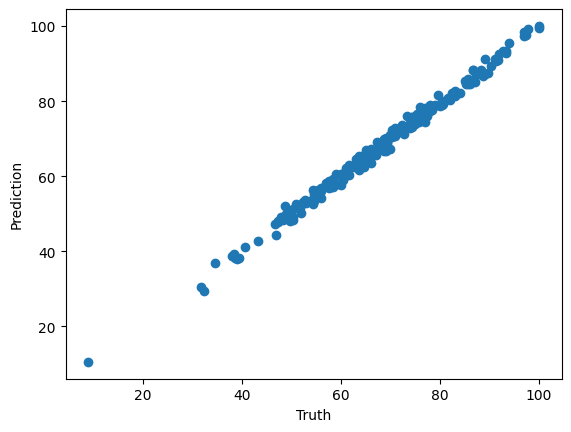

In [172]:
plt.scatter(y_test, y_pred)
plt.xlabel('Truth')
plt.ylabel('Prediction')

##### Difference between the test values and the predicted values

In [173]:
pred_df=pd.DataFrame({'Truth':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Truth,Predicted Value,Difference
975,74.333333,75.828125,-1.494792
558,64.333333,62.968750,1.364583
222,60.666667,60.640625,0.026042
899,75.000000,74.015625,0.984375
913,58.333333,57.875000,0.458333
...,...,...,...
427,68.333333,67.906250,0.427083
72,46.666667,47.296875,-0.630208
129,50.333333,51.203125,-0.869792
333,83.000000,81.375000,1.625000
